In [1]:
import numpy
import time
import tensorflow as tf
from matplotlib import pyplot as plt

M=1
delta = 0.0005

2023-02-28 10:47:37.905176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 10:47:38.339571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 10:47:38.339601: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 10:47:39.802361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
class ExponentialBoundaryCondition(tf.keras.layers.Layer):    
    def __init__(self, exp=1.0, trainable=True):
        tf.keras.layers.Layer.__init__(self)
        # This is the parameter controlling the shape of the exponent:
        self.exponent = tf.Variable(exp, trainable=trainable, dtype=tf.float32)

    def call(self, inputs):

        return tf.exp(- (self.exponent * inputs) **2 / 2.)

In [3]:
class NeuralWavefunction(tf.keras.layers.Layer):
    def __init__(self):
        tf.keras.layers.Layer.__init__(self)
        
        self.layer1 = tf.keras.layers.Dense(32)
        self.layer2 = tf.keras.layers.Dense(32)
        self.layer3 = tf.keras.layers.Dense(1)
    
        self.norm   = 1.0
        
        # This is an exponent for normalization:
        self.exp = ExponentialBoundaryCondition()


    def call(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = tf.nn.tanh(x)
        x = self.layer2(x)
        x = tf.nn.tanh(x)
        x = self.layer3(x)

        boundary_condition = self.exp(inputs)

        output = self.norm*x*boundary_condition
        return output

    
    def update_normalization(self, inputs):
        # Inputs is expected to be a range of parameters along an x axis.
        value = self.call(inputs)
        N = value ** 2

        delta = inputs[1]-inputs[0]

        N = tf.reduce_sum(N) * delta
        self.norm *= 1/tf.sqrt(N)

        # The normalization condition is that the integral of the wavefunction squared
        # should be equal to 1 (probability sums to 1.)

        return

In [4]:
# This is preparing input data that is differentiable:
_x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
_x = _x.reshape((_x.shape[0], 1))

x = tf.Variable(_x, trainable = True)

2023-02-28 10:47:42.175378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-28 10:47:42.175665: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-28 10:47:42.175717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LiverpoolLaptop): /proc/driver/nvidia/version does not exist
2023-02-28 10:47:42.176836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
boson_nn = NeuralWavefunction()
boson_nn.update_normalization(x)
boson_y = boson_nn(x)

fermion_nn = NeuralWavefunction()
fermion_nn.update_normalization(x)
fermion_y = fermion_nn(x)

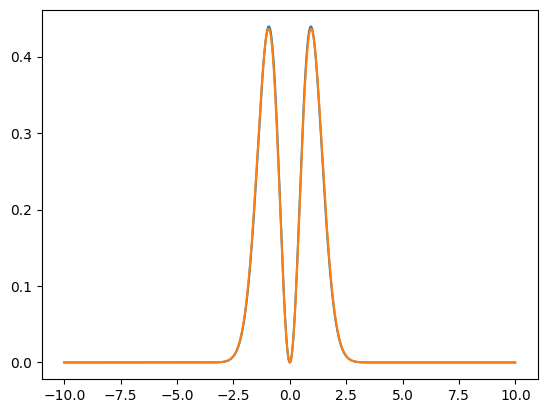

In [6]:
plt.plot(x.numpy(), (boson_y**2).numpy(), label="boson")
plt.plot(x.numpy(), (fermion_y**2).numpy(), label="fermion")

$$
    H=p^2
$$

In [19]:
def energy_computation(boson_wf, fermion_wf, inputs, delta):
    # This function takes the inputs (assumed to be a range of real value parameters)
    # And computes the expectation value of the energy.
    
    boson_tape = tf.GradientTape()
    fermion_tape = tf.GradientTape()
    # This is the value of the wave function:
    with boson_tape:
        boson_of_x = boson_wf(inputs)
    with fermion_tape:
        fermion_of_x = fermion_wf(inputs)
    
    # This is the first derivative of the wave function:
    boson_prime_dx = boson_tape.gradient(boson_of_x, inputs)
    fermion_prime_dx = fermion_tape.gradient(fermion_of_x, inputs)

    # Now we can compute integrals:
    # TODO: Check normalization
    normalization = tf.reduce_sum(boson_of_x**2)*tf.reduce_sum(fermion_of_x**2) * delta
    
    # 
    # boson_pe = (0.5 * M)*(boson_of_x**2)*(inputs**2)
    boson_pe = 0.5*((boson_wf(tf.roll(inputs,1,0))-boson_wf(tf.roll(inputs,-1,0)))/2.)**2 # V(phi)=0
    boson_pe = tf.reduce_sum(boson_pe)*delta    
    
    boson_ke = (1.0 / (2*M))*(boson_prime_dx**2)
    boson_ke = tf.reduce_sum(boson_ke)*delta

    # TODO: where does mass go? 
    fermion_pe = (fermion_of_x**2-0.5)
    fermion_pe = tf.reduce_sum(fermion_pe)*delta

    # fermion(x+1)^dagger*fermion(x) + fermion(x)^{dagger}*fermion(x+1)
    fermion_ke =  (1.0 / 2.0)*fermion_prime_dx
    fermion_ke = tf.reduce_sum(fermion_ke)*delta

    energy = (boson_ke + boson_pe + fermion_ke + fermion_pe) / normalization
    
    return energy

In [20]:
energy_computation(boson_nn, fermion_nn, x, delta)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.004072111>

In [9]:
def generate_input(delta):
    # Create fresh input data:
    _x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
    _x = _x.reshape((_x.shape[0], 1))

    x = tf.Variable(_x, trainable = True)

    return x

def training_step(boson_wf, fermion_wf, optimizer, delta):
    # Clear all gradients from the optimizer:
    exterior_tape = tf.GradientTape(persistent=True)
    
    x = generate_input(delta)

    boson_wf.update_normalization(x)
    fermion_wf.update_normalization(x)
    
    # Compute the energy:
    with exterior_tape:
        energy = energy_computation(boson_wf, fermion_wf, x, delta)

    # We back-prop'd through the wave function once already in the energy computation.  Clear the gradients:
    
    boson_gradients = exterior_tape.gradient(energy, boson_wf.trainable_variables)
    fermion_gradients = exterior_tape.gradient(energy, fermion_wf.trainable_variables)   

    optimizer.apply_gradients(zip(boson_gradients, boson_wf.trainable_variables))
    optimizer.apply_gradients(zip(fermion_gradients, fermion_wf.trainable_variables))
    
    # Lastly, update the normaliztion 
    boson_wf.update_normalization(x)
    fermion_wf.update_normalization(x)

    return  energy


In [10]:
type(generate_input(delta))

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [23]:
boson_nn = NeuralWavefunction()
boson_nn.update_normalization(x)
boson_y = boson_nn(x)

fermion_nn = NeuralWavefunction()
fermion_nn.update_normalization(x)
fermion_y = fermion_nn(x)
delta = 0.0001

x = generate_input(delta)

optimizer = tf.keras.optimizers.Adam()
optimizer.build(boson_nn.trainable_variables+fermion_nn.trainable_variables)
energy_history = []
step_history = []

for i in range(100):
    start = time.time()
    energy = training_step(boson_nn, fermion_nn, optimizer, delta)
    end = time.time()
    if i % 10 == 0: print(f"Energy :{energy.numpy()}, {end - start:.2}s per step")
    
    
    energy_history.append(energy.numpy())
    step_history.append(i)

Energy :-0.000752307241782546, 1.9s per step
Energy :-0.0006979869212955236, 2.0s per step
Energy :-0.0006154866423457861, 2.0s per step
Energy :-0.0006872624508105218, 2.1s per step
Energy :-0.0006651242729276419, 1.8s per step
Energy :-0.0007933758897706866, 2.0s per step


KeyboardInterrupt: 